## 2D attempt at solving the bidomain equations:

In [1]:
from fenics import *
import numpy as np
from configs import *
from utils import *
import matplotlib.pyplot as plt
from tqdm import tqdm

### Generating a mesh:

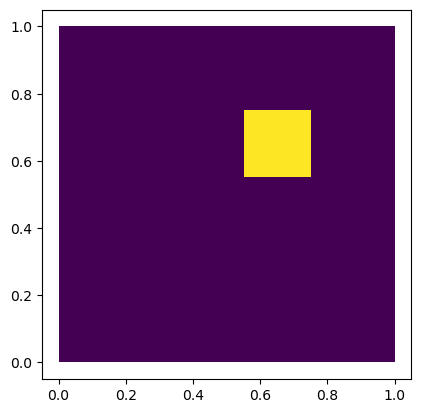

In [2]:
mesh, cellfunction, facetfunction = mesh_maker()
torsomesh = SubMesh(mesh, cellfunction, 0)
heartmesh = SubMesh(mesh, cellfunction, 1)
plot(cellfunction)

### Bidomain model:

In [3]:
# Define function space
P1 = FiniteElement("P", triangle, 2)
element = MixedElement([P1, P1, P1])
V = FunctionSpace(mesh, element)
V1 = FunctionSpace(mesh, P1)

# Define test functions
phi, psi, theta = TestFunctions(V)

# Define functions
v = Function(V)
v_n = Function(V)

V_m, u, w = split(v)
V_m_n, u_n, w_n = split(v_n)

In [4]:
# defining expressions for later use

# V_m = v[0], u = v[1], w = v[2]
# Ionic current
I_ion = Expression(
    "-v[2]/TAU_IN*pow((v[0] - V_MIN),2)*(V_MAX - v[0])/(V_MAX - V_MIN) + 1/TAU_OUT*(v[0] - V_MIN)/(V_MAX - V_MIN)",
    TAU_IN=TAU_IN,
    TAU_OUT=TAU_OUT,
    V_MIN=V_MIN,
    V_MAX=V_MAX,
    v=v,
    degree=2,
)
# Gating variable
g = Expression(
    "v[0] < V_GATE ? v[2]/TAU_OPEN - 1/TAU_OPEN/pow((V_MAX - V_MIN),2) : v[2]/TAU_CLOSE",
    TAU_OPEN=TAU_OPEN,
    TAU_CLOSE=TAU_CLOSE,
    V_GATE=V_GATE,
    V_MAX=V_MAX,
    V_MIN=V_MIN,
    v=v,
    degree=2,
)
# Fiber vector field
fibers = Expression(
    (
        "x[1]/sqrt(pow(x[0],2) + pow(x[1],2) + DOLFIN_EPS)",
        "-x[0]/sqrt(pow(x[0],2) + pow(x[1],2) + DOLFIN_EPS)",
    ),
    degree=2,
)
# Applied stimulus
I_app = Expression(
    "exp(-pow(x[0]-X, 2)/size - pow(x[1]-Y, 2)/size - pow(t/t_act, 2))",
    X=X,
    Y=Y,
    t_act=T_ACT,
    t=0,
    size=(X + Y) / 2,
    degree=2,
)  # nije kao u radu

In [5]:
# defining UFL language parts

# conductivities
sigma_il = Constant(SIGMA_IL)
sigma_it = Constant(SIGMA_IT)
sigma_el = Constant(SIGMA_EL)
sigma_et = Constant(SIGMA_ET)
sigma_tlt = Constant(SIGMA_TLT)

d = mesh.topology().dim()

sigma_i = sigma_it * Identity(d) + (sigma_il - sigma_it) * outer(fibers, fibers)
sigma_e = sigma_et * Identity(d) + (sigma_el - sigma_et) * outer(fibers, fibers)
sigma_t = sigma_tlt * Identity(d)

# Constants used in variational forms
dt = Constant(DT)
A_m = Constant(A_M)
C_m = Constant(C_M)

In [6]:
# Define new measures associated with the interior domains and
# exterior boundaries
dx = Measure("dx")(subdomain_data=cellfunction)
ds = Measure("ds")(subdomain_data=facetfunction)

In [7]:
# Define variational problem
F = (
    A_m * (C_m * (V_m - V_m_n) + dt * I_ion) * phi * dx(1)
    + dt * inner(dot(sigma_i, grad(V_m + u)), grad(phi)) * dx(1)
    - dt * A_m * I_app * phi * dx(1)
)
F += (
    inner(dot(sigma_i + sigma_e, grad(u)), grad(psi)) * dx(1)
    + inner(dot(sigma_i, grad(V_m)), grad(psi)) * dx(1)
    + inner(dot(sigma_t, grad(u)), grad(psi)) * dx(0)
)
F += (w - w_n + dt * g) * theta * dx(1)

In [8]:
# Initial conditions
V_m_0 = Expression("V_MIN", V_MIN=V_MIN, degree=0)
w_0 = Expression("1/pow((V_MAX - V_MIN), 2)", V_MIN=V_MIN, V_MAX=V_MAX, degree=0)

V_m_n, u_n, w_n = v_n.split(deepcopy=True)
V_m, u, w = v.split(deepcopy=True)

V_m_n = project(V_m_0, V1)
w_n = project(w_0, V1)

In [ ]:
# Time-stepping
t = 0
for n in tqdm(range(NUM_STEPS)):
    # Update current time
    t += DT

    # Solve variational problem for time step
    # set_log_active(False)
    solver = custom_solver(F, v, tol_abs=1e-3, tol_rel=1e-3)
    solver.solve()

    # Update previous solution
    v_n.assign(v)

In [ ]:
# Plot solution and gradient
plot(V_m, title="$u$", colorbar=True)
plot(w, title="$V_m$")
plot(u, title="$u$")